In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import (
    MinMaxScaler,
    PowerTransformer,
    RobustScaler,
)


# classificador referência
from sklearn.dummy import DummyClassifier

# estudo lineares
from sklearn.linear_model import LogisticRegression

# estudo árvores
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# estudo SVM
# from sklearn.svm import SVC

# estudo kNN
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

from src.auxiliares import dataframe_coeficientes
from src.config import DADOS_TRATADOS
from src.graficos import plot_comparar_metricas_modelos, plot_coeficientes
from src.models import RANDOM_STATE
from src.models import (
    grid_search_cv_classificador,
    treinar_e_validar_modelo_classificacao,
    organiza_resultados,
)

sns.set_theme(palette="bright")

In [4]:
df = pd.read_parquet(DADOS_TRATADOS)

df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V19,V20,V21,V23,V24,V26,V27,V28,Amount,Class
0,25344.0,-0.995183,-0.039833,1.587280,-1.889184,0.086393,0.110665,0.371166,-0.181099,-1.065219,...,0.382649,-0.103440,0.053965,-0.090478,-0.286068,-0.476159,-0.405522,-0.155737,32.92,0
1,25344.0,-1.189360,1.156971,1.368210,-0.232449,-0.034136,-0.324731,0.401403,0.241093,-0.067642,...,-0.168669,0.196165,-0.209365,0.141775,0.171039,0.075594,0.366013,0.232066,0.89,0
2,25345.0,-1.603479,-0.275395,3.446021,3.525447,-0.959825,1.328505,-0.355322,0.293210,0.672573,...,1.252910,0.582112,-0.000287,-0.204721,0.486938,0.533273,0.421326,0.073160,185.09,0
3,25348.0,1.096714,-1.049339,-0.073346,-1.001950,0.084768,1.947188,-0.926699,0.628543,-0.716949,...,-0.133941,0.058939,0.123027,-0.038933,-1.871220,-0.142292,0.059422,-0.007457,79.71,0
4,25349.0,1.262724,0.292562,0.523730,0.614042,-0.429046,-0.978012,0.097620,-0.236076,-0.037052,...,-0.120721,-0.060064,-0.252002,0.130210,0.389602,0.093132,-0.025331,0.019989,0.89,0


In [5]:
coluna_min_max = ["Time"]

coluna_power_transformer = ["Amount"]

target = ["Class"]

colunas_robust_scaler = [
    coluna for coluna in df.columns if coluna not in (
        coluna_min_max + coluna_power_transformer + target
    )
]

colunas_robust_scaler

['V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V14',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20',
 'V21',
 'V23',
 'V24',
 'V26',
 'V27',
 'V28']

In [24]:
X = df.drop(columns=target)
y = df[target].values.ravel()

In [7]:
preprocessamento = ColumnTransformer(
    transformers=[
        ("min_max", MinMaxScaler(), coluna_min_max),
        ("robust", RobustScaler(), colunas_robust_scaler),
        ("power_transform", PowerTransformer(), coluna_power_transformer),
    ]
)

In [8]:
scale_pos_weight = np.bincount(y)[0] / np.bincount(y)[1]
scale_pos_weight

520.0873983739838

In [9]:
classificadores = {
    "DummyClassifier": {
        "preprocessor": None,
        "classificador": DummyClassifier(strategy="stratified"),
    },
    "LogisticRegression": {
        "preprocessor": preprocessamento,
        "classificador": LogisticRegression(class_weight="balanced"),
    },
    "DecisionTreeClassifier": {
        "preprocessor": None,
        "classificador": DecisionTreeClassifier(class_weight="balanced"),
    },
    "LGBMClassifier": {
        "preprocessor": None,
        "classificador": LGBMClassifier(
            random_state=RANDOM_STATE,
            n_jobs=-1,
            verbose=-1,
            scale_pos_weight=scale_pos_weight,
        ),
    },
    "XGBClassifier": {
        "preprocessor": None,
        "classificador": XGBClassifier(
            random_state=RANDOM_STATE, n_jobs=-1, scale_pos_weight=scale_pos_weight
        ),
    },
    # "SVC": {
    #     "preprocessor": preprocessamento,
    #     "classificador": SVC(class_weight="balanced", cache_size=1000),
    # },
    "KNeighborsClassifier": {
        "preprocessor": preprocessamento,
        "classificador": KNeighborsClassifier(),
    },
}

In [10]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

In [11]:
resultados = {
    nome_modelo: treinar_e_validar_modelo_classificacao(X, y, kf, **classificador)
    for nome_modelo, classificador in classificadores.items()
}

df_resultados = organiza_resultados(resultados)

df_resultados

,model,fit_time,score_time,test_accuracy,test_balanced_accuracy,test_f1,test_precision,test_recall,test_roc_auc,test_average_precision,time_seconds
0,DummyClassifier,0.144687,0.140312,0.996197,0.499052,0.0,0.0,0.0,0.498994,0.001911,0.284999
1,DummyClassifier,0.117657,0.12766,0.996529,0.499218,0.0,0.0,0.0,0.49916,0.001911,0.245316
2,DummyClassifier,0.112332,0.67145,0.995651,0.498779,0.0,0.0,0.0,0.499101,0.001911,0.783782
3,DummyClassifier,0.38124,0.205992,0.996314,0.499121,0.0,0.0,0.0,0.499013,0.001931,0.587232
4,DummyClassifier,0.120768,0.286066,0.996255,0.504132,0.010309,0.010526,0.010101,0.499072,0.001931,0.406834
5,LogisticRegression,6.250301,0.614324,0.979776,0.959315,0.150696,0.081923,0.938776,0.994985,0.834228,6.864625
6,LogisticRegression,5.061542,0.363814,0.977045,0.947763,0.132646,0.071485,0.918367,0.985635,0.803715,5.425355
7,LogisticRegression,6.508207,0.383255,0.976109,0.937109,0.125625,0.067536,0.897959,0.967787,0.830496,6.891462
8,LogisticRegression,4.255587,0.302575,0.978586,0.938865,0.139498,0.075616,0.89899,0.975453,0.788056,4.558161
9,LogisticRegression,4.947328,1.046157,0.975212,0.937175,0.122843,0.065926,0.89899,0.971713,0.816391,5.993485


In [15]:
df_resultados.groupby("model").mean().sort_values("test_average_precision")

,fit_time,score_time,test_accuracy,test_balanced_accuracy,test_f1,test_precision,test_recall,test_roc_auc,test_average_precision,time_seconds
model,,,,,,,,,,
DummyClassifier,0.175337,0.286296,0.996189,0.50006,0.002062,0.002105,0.00202,0.499068,0.001919,0.461633
LGBMClassifier,20.036515,0.671388,0.936335,0.889069,0.108795,0.065229,0.84162,0.883363,0.049245,20.707903
DecisionTreeClassifier,23.837596,0.315555,0.999138,0.868693,0.766545,0.798719,0.737745,0.868693,0.589604,24.153151
KNeighborsClassifier,3.03117,454.211974,0.999431,0.879065,0.836118,0.933296,0.758235,0.921583,0.803347,457.243144
LogisticRegression,5.404593,0.542025,0.977346,0.944045,0.134262,0.072497,0.910616,0.979115,0.814577,5.946618
XGBClassifier,11.052709,1.076157,0.99954,0.91458,0.873822,0.923933,0.829293,0.978712,0.864445,12.128866


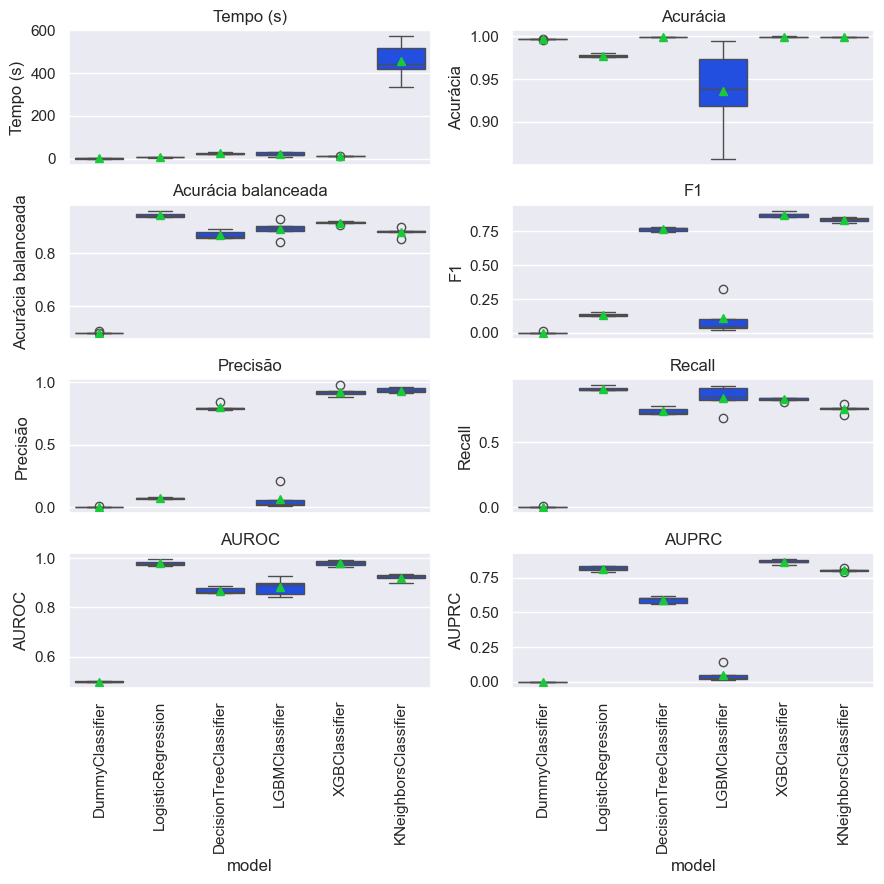

In [16]:
plot_comparar_metricas_modelos(df_resultados)

In [17]:
treinar_e_validar_modelo_classificacao(
    X, y, kf, **classificadores["XGBClassifier"]
)

{'fit_time': array([9.00751138, 9.4682672 , 8.94692421, 9.54329133, 8.06477952]),
 'score_time': array([0.53486848, 0.70866561, 1.01876283, 0.5284946 , 0.62411571]),
 'test_accuracy': array([0.99947343, 0.99955144, 0.99955144, 0.99947343, 0.99964895]),
 'test_balanced_accuracy': array([0.91825988, 0.91320669, 0.91829896, 0.90396224, 0.91917238]),
 'test_f1': array([0.85863874, 0.87567568, 0.87700535, 0.85561497, 0.90217391]),
 'test_precision': array([0.88172043, 0.93103448, 0.92134831, 0.90909091, 0.97647059]),
 'test_recall': array([0.83673469, 0.82653061, 0.83673469, 0.80808081, 0.83838384]),
 'test_roc_auc': array([0.99093203, 0.98772248, 0.97278333, 0.96243721, 0.97968508]),
 'test_average_precision': array([0.88003775, 0.86251372, 0.85949564, 0.84151465, 0.87866162])}

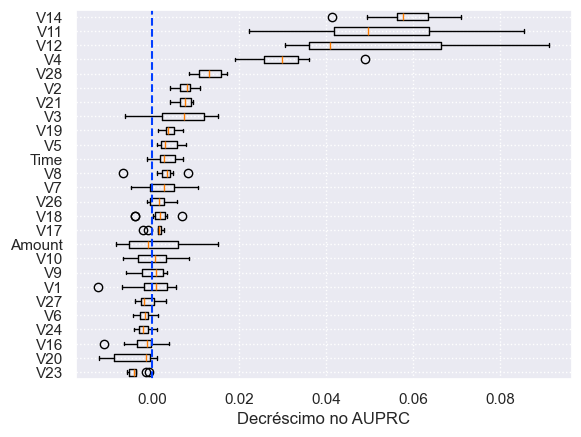

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=RANDOM_STATE, stratify=y
)

clf = classificadores["XGBClassifier"]["classificador"]

clf.fit(X_train, y_train)

perm_imp = permutation_importance(
    clf,
    X_test,
    y_test,
    n_repeats=10,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    scoring="average_precision",
)

fig, ax = plt.subplots()

ordem = perm_imp.importances_mean.argsort()

ax.boxplot(perm_imp.importances[ordem].T, vert=False, tick_labels=X.columns[ordem])
ax.axvline(x=0, linestyle="--")
ax.set_xlabel("Decréscimo no AUPRC")
ax.grid(True, linestyle=":")

plt.show()

In [22]:
perm_imp.importances_mean

array([ 3.23300189e-03, -2.41476083e-04,  7.63037955e-03,  6.71769497e-03,
        3.03818287e-02,  3.85434203e-03, -1.77987040e-03,  2.34523799e-03,
        2.75672155e-03, -2.26593650e-05,  4.27385870e-04,  5.27993095e-02,
        5.06711084e-02,  5.81839672e-02, -2.12983136e-03,  1.31584265e-03,
        1.41180742e-03,  4.05299080e-03, -3.87884145e-03,  7.53903535e-03,
       -3.88730491e-03, -1.86551146e-03,  1.52266298e-03, -1.05153253e-03,
        1.30199881e-02,  8.53935789e-04])

In [25]:
X.columns[perm_imp.importances_mean < 0.01]

Index(['Time', 'V1', 'V2', 'V3', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V16',
       'V17', 'V18', 'V19', 'V20', 'V21', 'V23', 'V24', 'V26', 'V27',
       'Amount'],
      dtype='object')

In [26]:
X = X.drop(columns=X.columns[perm_imp.importances_mean < 0.01])

X.columns

Index(['V4', 'V11', 'V12', 'V14', 'V28'], dtype='object')

In [61]:
treinar_e_validar_modelo_classificacao(
    X, y, kf, **classificadores["XGBClassifier"]
)

{'fit_time': array([2.57639337, 2.59338832, 2.50906968, 2.65340996, 2.56507277]),
 'score_time': array([0.49041486, 0.57077527, 0.54356241, 0.59278655, 0.62467599]),
 'test_accuracy': array([0.9992784 , 0.99920039, 0.9992394 , 0.99937591, 0.99941492]),
 'test_balanced_accuracy': array([0.89779309, 0.91303083, 0.90286582, 0.89887266, 0.92913661]),
 'test_f1': array([0.80829016, 0.79802956, 0.80203046, 0.83157895, 0.85      ]),
 'test_precision': array([0.82105263, 0.77142857, 0.7979798 , 0.86813187, 0.84158416]),
 'test_recall': array([0.79591837, 0.82653061, 0.80612245, 0.7979798 , 0.85858586]),
 'test_roc_auc': array([0.98247359, 0.96439937, 0.94921208, 0.95855538, 0.96267387]),
 'test_average_precision': array([0.82616921, 0.83458699, 0.80100255, 0.80990992, 0.86245195])}

In [27]:
param_grid = {
    "clf__max_depth": [3, 6, 10],  # Profundidade da árvore
    # "clf__min_child_weight": [1, 3, 5],  # Peso mínimo de uma folha
    # "clf__gamma": [0, 0.1, 0.3],  # Redução mínima de perda para uma divisão
    "clf__subsample": [0.6, 0.8, 1.0],  # Proporção de amostras usadas para cada árvore
    "clf__colsample_bytree": [0.6, 0.8, 1.0],  # Proporção de features para cada árvore
    # "clf__learning_rate": [0.1, 0.3, 0.5],  # Taxa de aprendizado
    # "clf__n_estimators": [10, 50, 100],  # Número de árvores
    "clf__reg_lambda": [1, 2, 5],  # Regularização L2
    "clf__reg_alpha": [0, 0.5, 1],  # Regularização L1
    # "clf__scale_pos_weight": [1, scale_pos_weight],  # Peso das classes
}

In [28]:
clf = XGBClassifier(random_state=RANDOM_STATE, n_jobs=-1, scale_pos_weight=scale_pos_weight)

grid_search = grid_search_cv_classificador(
    clf, param_grid, kf, None, refit_metric="average_precision"
)

grid_search

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('clf',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_types=None,
                                                      feature_weights=Non...
                                                      n_estimators=None,
                                                      n_jobs=-1,
                                                      num_parallel_tree=None, ...))]),
             n_jobs=-1,
             param_grid={'clf__colsample_bytree': [0.6, 0.8, 1.0],
                         'clf__max_depth': [3, 6, 10],
                         'clf__reg_alpha': [0, 0.5, 1],
                         'clf__reg_lambda': [1, 2, 5],
                         'clf__subsample': [0.6, 0.8, 1.0]},
             refit='average_precision',
             scoring=['accuracy', 'balanced_accuracy', 'f1', 'precision',
                      'recall', 'roc_auc', 'average_precision'],
             verbose=1)

In [ ]:
grid_search.fit(X, y)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


In [ ]:
grid_search.best_params_

In [ ]:
grid_search.best_score_

In [ ]:
grid_search.best_estimator_

In [ ]:
colunas_test = [coluna for coluna in df_resultados.columns if coluna.startwith("test")]
colunas_test_mean = ["mean_" + coluna for coluna in colunas_test]
colunas_test_mean

In [ ]:
for coluna in colunas_test_mean:
    print(f"{coluna}: {grid_search.cv_results_[coluna][grid_seacrh.best_index_]}")

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

plot_importance(
    grid_search.best_estimator_["clf"],
    ax=ax,
    importance_type="weight",
    tittle="Feature importance by weight"
)

plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

plot_importance(
    grid_search.best_estimator_["clf"],
    ax=ax,
    importance_type="gain",
    tittle="Feature importance by gain",
    values_format={"v:.2gf"}
)

plt.show()